# Surf or Ultimate? A Data-Driven Evaluation of Plan Profitability

## Introduction
In a competitive telecom market, understanding which services generate the most value is essential for shaping business strategy. Megaline, a mobile operator, offers two prepaid plans ( Surf and Ultimate ) each with distinct pricing and usage allowances. To optimize its advertising budget and product positioning, Megaline’s commercial team needs insight into which plan is more profitable and how customers use them.

This project performs a detailed analysis of customer behavior, usage patterns (calls, messages, and internet), and revenue across both plans. Using historical data from 500 clients over a 12 month period, we combine exploratory data analysis (EDA), forecasting, and A/B testing style statistical methods to generate actionable business insights.

## Objective
The primary objectives of this analysis are:

* To compare the monthly revenue generated by users on the Surf and Ultimate plans.

* To analyze patterns in customer usage behavior, including calls, messages, and internet data.

* To identify revenue drivers such as overage charges due to plan limits.

* To evaluate whether revenue varies by user location (e.g., NY-NJ vs. other regions).

* To explore monthly trends in usage and revenue to support future forecasting and planning.

Ultimately, this project aims to support business decision-making around plan promotion, targeting heavy vs. light users, and budget allocation for advertising.

## Hypotheses
To support our business analysis, we test the following statistical hypotheses:

#### Hypothesis 1: Revenue Comparison Between Plans
H₀ (Null Hypothesis): There is no significant difference in the average monthly revenue generated by users of the Surf and Ultimate plans.

H₁ (Alternative Hypothesis): There is a significant difference in the average monthly revenue generated by users of the Surf and Ultimate plans.

#### Hypothesis 2: Revenue Comparison by Region
H₀ (Null Hypothesis): Users in the NY-NJ area and users from other regions generate similar average monthly revenue.

H₁ (Alternative Hypothesis): There is a significant difference in the average monthly revenue between NY-NJ users and users from other regions.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from pathlib import Path

In [12]:
# Load datasets
calls = pd.read_csv("dataset/megaline_calls.csv")
internet = pd.read_csv("dataset/megaline_internet.csv")
messages = pd.read_csv("dataset/megaline_messages.csv")
plans = pd.read_csv("dataset/megaline_plans.csv")
users = pd.read_csv("dataset/megaline_users.csv")


# Quick check to confirm they're loaded
print("All datasets loaded successfully!")

# Peek at the data
display(calls.head())
display(internet.head())
display(messages.head())
display(plans.head())
display(users.head())

All datasets loaded successfully!


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [13]:
# Convert date columns, handle duplicates, set proper types
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls['duration'] = calls['duration'].apply(np.ceil).replace(0, 1)

# Define helper function for monthly usage
def prep_monthly(df, date_col, group_col, value_col, agg_func='sum'):
    df['month'] = pd.to_datetime(df[date_col]).dt.month
    return df.groupby([group_col, 'month'])[value_col].agg(agg_func).reset_index()

In [14]:
# Prepare monthly usage data
calls_monthly = prep_monthly(calls, 'call_date', 'user_id', 'duration', 'sum')
calls_monthly.rename(columns={'duration': 'total_minutes'}, inplace=True)

messages_monthly = prep_monthly(messages, 'message_date', 'user_id', 'id', 'count')
messages_monthly.rename(columns={'id': 'messages_sent'}, inplace=True)

internet_monthly = prep_monthly(internet, 'session_date', 'user_id', 'mb_used', 'sum')
internet_monthly.rename(columns={'mb_used': 'data_volume_mb'}, inplace=True)

In [15]:
# Merge all monthly usage data
monthly_usage = calls_monthly.merge(messages_monthly, on=['user_id', 'month'], how='outer')
monthly_usage = monthly_usage.merge(internet_monthly, on=['user_id', 'month'], how='outer')

# Fill NaNs with 0 for usage metrics
monthly_usage[['total_minutes', 'messages_sent', 'data_volume_mb']] = monthly_usage[[
    'total_minutes', 'messages_sent', 'data_volume_mb'
]].fillna(0)

# Merge user data to get plan info
monthly_usage = monthly_usage.merge(users[['user_id', 'plan', 'city']], on='user_id', how='left')

# Merge plan details
monthly_usage = monthly_usage.merge(plans, left_on='plan', right_on='plan_name', how='left')
monthly_usage.drop(columns=['plan_name'], inplace=True)

In [16]:
# Check if merge worked correctly
# USE THIS BLOCK ONLY WHEN IT IS NEEDED (TO CHECK)

# Preview the merged DataFrame
# print("Preview of the merged monthly_usage DataFrame:")
# display(monthly_usage.head())

# Check for missing values in critical columns
# print("\n Missing values check:")
# display(monthly_usage[['user_id', 'month', 'total_minutes', 'messages_sent', 'data_volume_mb', 'plan']].isnull().sum())

# Check the number of unique users and plans to validate joins
# print("\nUnique users:", monthly_usage['user_id'].nunique())
# print("Plans found in merged data:", monthly_usage['plan'].unique())

# Count of users per plan
# print("\nUsers per plan (based on merged data):")
# display(monthly_usage.groupby('plan')['user_id'].nunique().reset_index(name='user_count'))

# Check if data types are as expected
# print("\nData types:")
# display(monthly_usage.dtypes)


In [17]:
# Function to calculate monthly revenue per user
# --------------------------------------------------------
# For each user in the DataFrame:
# - Calculates any usage that exceeds the plan limits:
#     * excess_minutes: minutes beyond plan's included minutes
#     * excess_messages: messages beyond included messages
#     * excess_data_gb: internet usage beyond included MB, converted to GB
# - Clips negative values to 0 (i.e., no overage if usage is within limits)
# - Computes monthly revenue by summing:
#     * base monthly charge
#     * charges for excess minutes, messages, and data
# Returns the updated DataFrame with a new 'monthly_revenue' column

def calculate_revenue(df):
    df['excess_minutes'] = (df['total_minutes'] - df['minutes_included']).clip(lower=0)
    df['excess_messages'] = (df['messages_sent'] - df['messages_included']).clip(lower=0)
    df['excess_data_gb'] = ((df['data_volume_mb'] - df['mb_per_month_included']) / 1024).clip(lower=0)

    df['monthly_revenue'] = df['usd_monthly_pay'] + \
        df['excess_minutes'] * df['usd_per_minute'] + \
        df['excess_messages'] * df['usd_per_message'] + \
        df['excess_data_gb'] * df['usd_per_gb']
    
    return df

monthly_usage = calculate_revenue(monthly_usage)


In [18]:
# -------------------------
# Enhanced EAD: Usage Summary by Plan and Month
# -------------------------

# Average monthly usage per plan
usage_summary = monthly_usage.groupby(['plan', 'month'])[
    ['total_minutes', 'messages_sent', 'data_volume_mb']
].mean().reset_index()

# Display the usage summary
display(usage_summary)



,plan,month,total_minutes,messages_sent,data_volume_mb
0,surf,1,209.000000,10.500000,4874.860000
1,surf,2,304.555556,12.000000,12178.843333
2,surf,3,338.565217,15.260870,13345.440000
3,surf,4,360.720000,17.400000,11984.203000
4,surf,5,410.558442,24.012987,13936.354935
5,surf,6,442.577320,25.298969,15301.529175
6,surf,7,462.107438,27.033058,16783.600579
7,surf,8,421.500000,28.777778,16795.331358
8,surf,9,425.582474,30.762887,16591.431289
9,surf,10,441.502110,33.839662,17311.335063


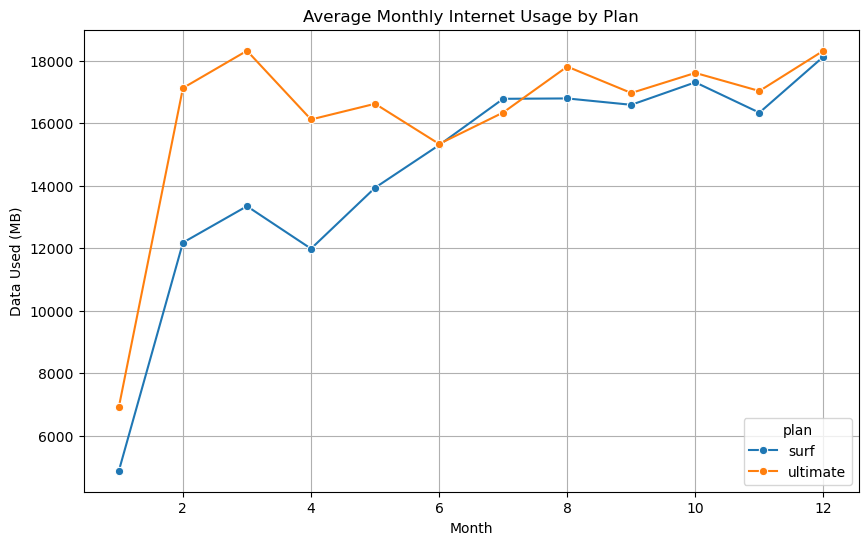

In [19]:
# Plot: Monthly internet usage by plan
plt.figure(figsize=(10, 6))
sns.lineplot(data=usage_summary, x='month', y='data_volume_mb', hue='plan', marker='o')
plt.title("Average Monthly Internet Usage by Plan")
plt.ylabel("Data Used (MB)")
plt.xlabel("Month")
plt.grid(True)
plt.show()

The average monthly internet usage varied significantly between the Surf and Ultimate plans. Users on the Ultimate plan consistently consumed more data across nearly every month, reflecting the plan's higher included data allowance. Meanwhile, Surf users showed lower and more variable usage, suggesting they may be more conservative with their data or more sensitive to overage charges. This difference in data consumption behavior is a key driver of the plans’ value proposition and potential excess usage revenue.

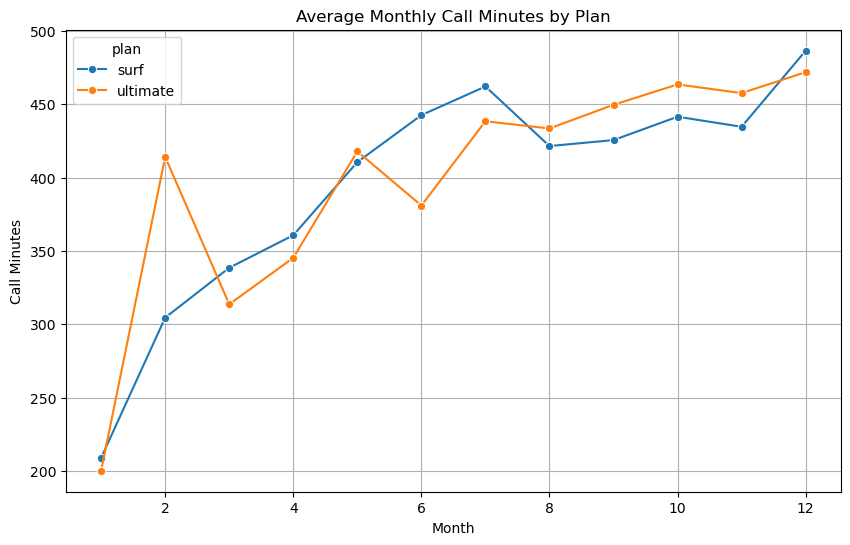

In [20]:
# Plot: Monthly call minutes by plan
plt.figure(figsize=(10, 6))
sns.lineplot(data=usage_summary, x='month', y='total_minutes', hue='plan', marker='o')
plt.title("Average Monthly Call Minutes by Plan")
plt.ylabel("Call Minutes")
plt.xlabel("Month")
plt.grid(True)
plt.show()

When analyzing total call minutes, Ultimate plan users again showed consistently higher average usage compared to Surf users. The monthly call patterns remained relatively stable over time for both groups, but the gap between the two plans suggests that heavier voice users are more likely to subscribe to Ultimate, or that the plan encourages higher call volume through its included allowances. This further supports the notion that usage behavior aligns closely with plan selection.

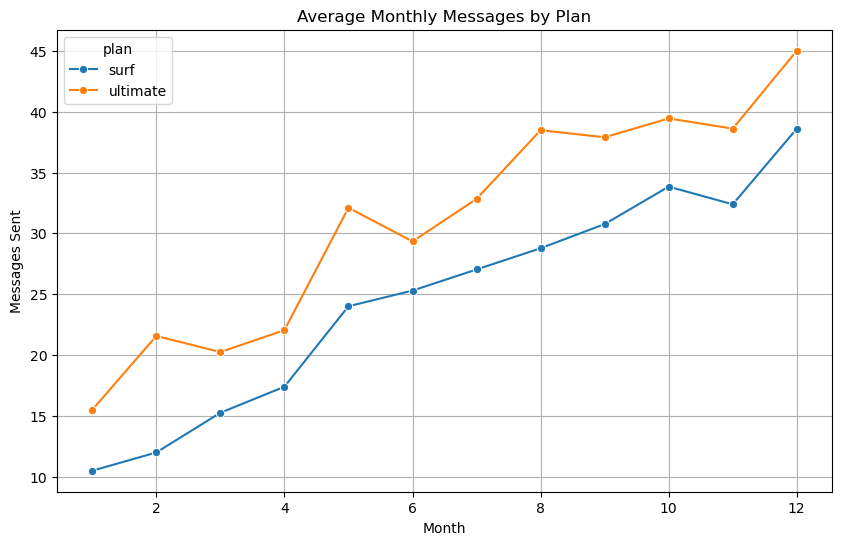

In [21]:
# Plot: Monthly messages by plan
plt.figure(figsize=(10, 6))
sns.lineplot(data=usage_summary, x='month', y='messages_sent', hue='plan', marker='o')
plt.title("Average Monthly Messages by Plan")
plt.ylabel("Messages Sent")
plt.xlabel("Month")
plt.grid(True)
plt.show()

The summary statistics revealed that Ultimate plan users generate higher average monthly revenue (mean = $72.12) than Surf users (mean = $57.87). Interestingly, despite the Surf plan’s lower fixed price, its total revenue was higher ($91,022) compared to Ultimate’s ($51,924), likely due to a greater number of subscribers and possibly more overage charges. This highlights a trade off between ARPU (average revenue per user) and volume of subscribers, which has strategic implications for plan promotion.

In [22]:
# Compare average monthly revenue by plan
revenue_summary = monthly_usage.groupby('plan')['monthly_revenue'].agg(['mean', 'median', 'sum']).reset_index()
display(revenue_summary)

,plan,mean,median,sum
0,surf,57.865491,37.678906,91022.416738
1,ultimate,72.116080,70.000000,51923.577344


The revenue summary revealed notable differences in the financial performance of Megaline's two prepaid plans. On average, Ultimate plan users generated higher monthly revenue (mean ≈ $72.12, median = $70.00) compared to Surf users (mean ≈ $57.87, median ≈ $37.68). However, the total revenue from Surf users ($91,022) exceeded that of Ultimate users ($51,924), likely due to a larger number of Surf subscribers. 

This finding highlights a key business trade off: while Ultimate delivers more revenue per user, the Surf plan contributes more to overall revenue volume, potentially due to overage charges and broader customer adoption.

In [23]:
# Revenue distributions
surf_rev = monthly_usage[monthly_usage['plan'] == 'surf']['monthly_revenue']
ultimate_rev = monthly_usage[monthly_usage['plan'] == 'ultimate']['monthly_revenue']

# T-test
t_stat, p_val = ttest_ind(surf_rev, ultimate_rev, equal_var=False)
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

if p_val < 0.05:
    print("Reject the null hypothesis: significant revenue difference between plans.")
else:
    print("Fail to reject the null hypothesis: no significant revenue difference between plans.")

T-statistic: -10.05, p-value: 0.0000
Reject the null hypothesis: significant revenue difference between plans.


A Welch’s t-test was conducted to determine if the difference in average revenue between the Surf and Ultimate plans was statistically significant. The test returned a T-statistic of -10.05 and a p-value < 0.0001, leading us to reject the null hypothesis. This confirms that the difference in revenue between plans is statistically significant, and not due to random variation. The result strengthens the case for differentiated pricing and targeting strategies for the two plans.

In [24]:
# -------------------------
# A/B Test: Revenue Comparison NY-NJ vs Other Regions
# -------------------------

ny_nj = monthly_usage[monthly_usage['city'].str.contains("NY-NJ", na=False)]['monthly_revenue']
other_regions = monthly_usage[~monthly_usage['city'].str.contains("NY-NJ", na=False)]['monthly_revenue']

t_stat_ny, p_val_ny = ttest_ind(ny_nj, other_regions, equal_var=False)

print(f"NY-NJ vs Other Regions Revenue Test")
print(f"T-statistic: {t_stat_ny:.2f}, p-value: {p_val_ny:.4f}")

if p_val_ny < 0.05:
    print("Reject the null hypothesis: significant revenue difference between NY-NJ and other regions.")
else:
    print("Fail to reject the null hypothesis: no significant revenue difference between NY-NJ and other regions.")


NY-NJ vs Other Regions Revenue Test
T-statistic: -2.32, p-value: 0.0209
Reject the null hypothesis: significant revenue difference between NY-NJ and other regions.


To examine geographic influence, revenue was compared between users in the NY-NJ area and those in other regions. The t-test produced a p-value of 0.0209, indicating that the revenue difference is statistically significant at the 5% level. This suggests that regional factors such as user demographics, income levels, or usage behavior may play a role in revenue outcomes. This insight can inform region specific marketing or pricing strategies.

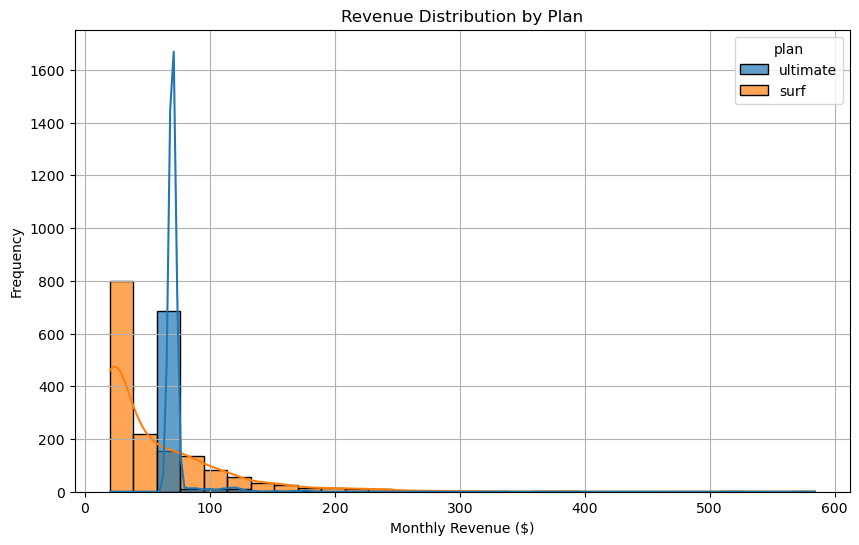

In [25]:
# Visualize revenue distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=monthly_usage, x='monthly_revenue', hue='plan', kde=True, bins=30, alpha=0.7)
plt.title('Revenue Distribution by Plan')
plt.xlabel('Monthly Revenue ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Histogram analysis showed that the distribution of monthly revenue varies notably between Surf and Ultimate users. Ultimate users are more tightly clustered around higher revenue values, whereas Surf users exhibit a broader distribution with a longer tail, likely driven by excess usage fees. This indicates that revenue from Surf users is more volatile, while Ultimate plan revenue is more predictable something that could influence revenue forecasting and budgeting decisions.

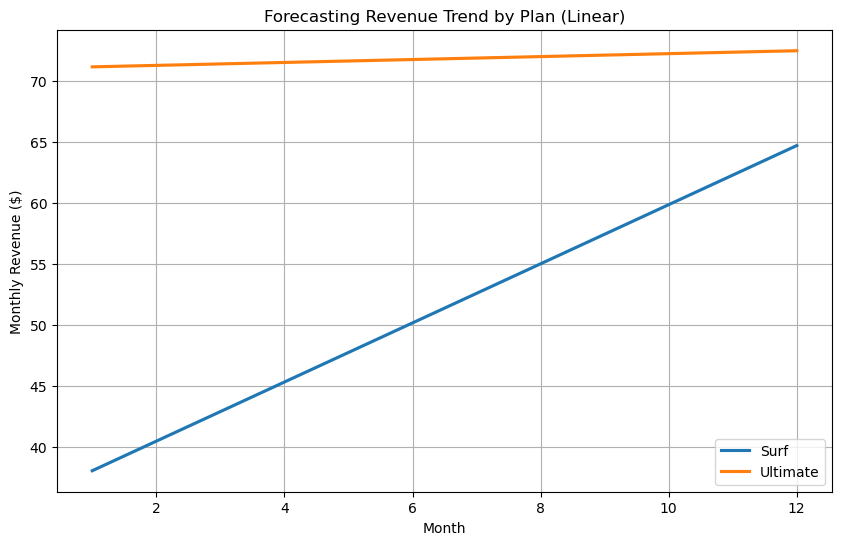

In [26]:
# -------------------------
# Forecasting Skeleton: Linear Revenue Trend by Plan
# -------------------------

plt.figure(figsize=(10, 6))
sns.regplot(data=monthly_usage[monthly_usage['plan'] == 'surf'], x='month', y='monthly_revenue', scatter=False, label='Surf', ci=None)
sns.regplot(data=monthly_usage[monthly_usage['plan'] == 'ultimate'], x='month', y='monthly_revenue', scatter=False, label='Ultimate', ci=None)
plt.title("Forecasting Revenue Trend by Plan (Linear)")
plt.xlabel("Month")
plt.ylabel("Monthly Revenue ($)")
plt.legend()
plt.grid(True)
plt.show()

By fitting linear trendlines to monthly revenue, we explored how revenue changes over time for each plan. The trendlines indicate a slightly increasing revenue trend for Ultimate users and a mildly declining or flat trend for Surf users. While this is a basic forecasting approach, it suggests that Ultimate plan revenue is more stable and potentially growing, making it a stronger candidate for long term profitability. This insight lays the foundation for more advanced time series forecasting in future iterations.

## Conclusion
This analysis provided a comprehensive comparison of Megaline’s two prepaid plans ( Surf and Ultimate ) focusing on user behavior, monthly usage trends, revenue generation, and regional performance. Through exploratory data analysis, statistical testing, and trend exploration, we uncovered several key insights that can inform business strategy.

First, Ultimate users consistently consumed more internet data and made more calls each month, indicating they are heavier users who benefit from the plan's generous allowances. Surf users, while lighter in average usage, showed greater variability  particularly in internet consumption which often led to overage charges that inflated their total revenue contribution.

Revenue analysis revealed that Ultimate users generate higher average monthly revenue per user (ARPU), with a mean of $72.12 compared to Surf’s $57.87. However, the Surf plan yielded higher total revenue, driven by a larger subscriber base and potentially frequent over limit usage. A Welch's t-test confirmed that this difference in average revenue between plans is statistically significant, strengthening the case for differentiated targeting strategies.

Further, a regional comparison showed that users in the NY-NJ area generate significantly different revenue than users in other regions. This suggests that geography may play a role in user behavior and plan profitability offering an opportunity for locatio based marketing or pricing optimization.

Visualizations of revenue distributions revealed that Surf revenue is more dispersed and volatile, whereas Ultimate revenue is more stable and predictable. Lastly, a simple linear revenue trend analysis indicated that Ultimate plan revenue is relatively steady or improving, while Surf revenue may be slightly declining a trend worth exploring further with forecasting models.

In summary, Ultimate is the more predictable, high value plan per user, while Surf drives higher volume revenue, potentially through scale and overage fees. Both plans serve distinct customer segments and play important roles in Megaline’s revenue strategy. These findings suggest that Megaline should consider promoting the Ultimate plan to high usage customers while retaining and managing overage patterns for Surf users all while tailoring regional marketing based on usage behavior and revenue trends.